# **The Replication Package of "Tracing Optimization for Performance Modeling and Regression Detection"**

## This is the analysis notebook that leverages program's trace data in order to:

1.   Preprocess the data (i.e., removing outliers, removing non-insightful features)
2.   Determing performance-sensitive functions based on:
    1. Shannon's Entropy (Dynamic)
    2. Coefficient of Variation (Dynamic)
    3. Performance Correlation (i.e., removing highly correlated features) (Dynamic)
    4. Feature Significance (i.e., features with a significant impact on the model) (Dynamic)
    5. StaPerfSens (i.e., based on static code features, such as lines of code, number of loops, etc.) (Static)
3.   Building performance models from the optimized trace data
4.   Evaluate the model's effectiveness in detecting performance regressions







## **Environment Initializations**

In [38]:
TRACE_DATA_PATH = './trace-data' # Directory containing trace data (i.e., trace-data)
MODELS_DIRECTORY_PATH = './perf-models' # Directory to save the models (i.e., perf-models)

In [39]:
import numpy as np
import pandas as pd
import json
import random
import re
import os
import matplotlib.pyplot as plt

from collections import defaultdict
import math
import scipy.stats
from scipy.stats import zscore, mannwhitneyu, shapiro, kstest
from scipy.cluster import hierarchy

from cliffs_delta import cliffs_delta

from ckwrap import ckmeans
from loess.loess_1d import loess_1d

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from scipy.stats import zscore

import pickle
from pycaret.regression import RegressionExperiment

import seaborn as sns

import statsmodels.api as sm

pd.options.display.max_columns = None

In [40]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

## **Determining performance-sensitive functions sets**

In [41]:
# Rounding a value into the closest base (e.g., for binning)
def custom_round(x, base=5, return_int=False):
    if base == 0:
        return x
    if return_int == True:
        return int(base * round(float(x)/base))
    else:
        return base * round(float(x)/base)

**Calculating the Shannon's Entropy**
We first remove the top 2.5% of the data in order to remove the outliers that have a high impact on the entropy values, and then, we calculate the Shannon's entropy for the preprocessed data.

In [42]:
def calculate_entropy(df):
    ent = {}
    for column in df.columns:
        numbers = df[column].to_list()
        percentile = np.percentile(numbers, 97.5)
        numbers = [i for i in numbers if i <= percentile]

        value,counts = np.unique(numbers, return_counts=True)

        entropy = scipy.stats.entropy(counts, base=None)

        if entropy > 0:
            ent[column] = entropy
    return dict(sorted(ent.items(), key=lambda item: item[1], reverse=True))

**Calculating the Coefficient of Variation**
We first remove the top 2.5% of the data in order to remove the outliers that have a high impact on the CV values, and then, we calculate the CV for the preprocessed data.

In [43]:
def calculate_cv(df):
    cvs = {}
    for column in df.columns:
        numbers = df[column].to_list()
        percentile = np.percentile(numbers, 97.5)
        numbers = [i for i in numbers if i <= percentile]

        cv = np.std(numbers, ddof=1) / (np.mean(numbers) + 0.00001)
        if np.isnan(cv):
            cv = 0.0

        if cv > 0:
            cvs[column] = cv

    return dict(sorted(cvs.items(), key=lambda item: item[1], reverse=True))

In [44]:
# Scaling a list into new boundaries (e.g., from x to y)
def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(l, to_min, to_max):
    return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

In [45]:
def show_corr_heatmap(df, columns):
    sns.set(rc={'figure.figsize':(50, 75)})

    corr = df[columns].corr()
    matrix = np.triu(corr)
    heatmap_plot = sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True,
                annot_kws={'fontsize':11, 'fontweight':'bold'},
                square=True, mask = matrix, cbar=False)
    heatmap_fig = heatmap_plot.get_figure()

In [46]:
# Calculating various types of errors with the model's predictions and the true values
def get_errors(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mre = np.mean(np.abs(y_true - y_pred) / np.abs(y_true))
    r2 = r2_score(y_true, y_pred)

    mae = math.floor(mae * 1000)/1000.0
    mape = math.floor(mape * 1000)/1000.0
    mse = math.floor(mse * 1000)/1000.0
    rmse = math.floor(rmse * 1000)/1000.0
    mre = math.floor(mre * 1000)/1000.0

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

**Training the performance model.**
This function has two types for training the performance model:
1.   Only train the model without applying K-fold cross-validation.
2.   Evaluating the model's accuracy with a 10-fold cross validation.

In [47]:
def get_model(df, features, model, frac = 1, train_only = False):
    X = df[features]
    y = df['model_output']

    if train_only == True:
        model.fit(X, y)
        return model, None


    k = 10
    kf = KFold(n_splits=k, random_state=None)

    errors = {}
    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_kf, y_train_kf)

        y_pred_kf = model.predict(X_test_kf)

        errs = get_errors(y_test_kf, y_pred_kf)

        for e_name, e_value in errs.items():
            if e_name not in errors:
                errors[e_name] = []
            errors[e_name].append(e_value)

    # Calculate the average of the errors:
    for e_name, e_values in errors.items():
        average = np.mean(e_values)
        errors[e_name] = average

    return model, errors

In [48]:
def get_turning_points(input):
    points = []

    last_value = input[0]
    for i in range(1, len(input)):
        if input[i] != last_value:
            points.append(i)
            last_value = input[i]

    return points

In [49]:
def cluster_functions(input):
    clusters = {}
    for i in range(0, len(input)):
        if clusters.get(str(input[i]), 0) == 0:
            clusters[str(input[i])] = []
        clusters[str(input[i])].append(i)
    return clusters

**Clustering the functions into performance-sensitive and performance-insensitive groups.**
We first smooth the values of the data using loess function. Then, we calculate the first derivative of the smoothed data, and accordingly, we cluster the results into two groups.

In [50]:
def get_smooth_dxdy_clusters(input, number_of_clusters = 2):
    xout, yout, wout = loess_1d(np.arange(len(list(input.keys()))), np.array(list(input.values())))
    dydx = np.gradient(yout,xout)
    clusters = ckmeans(dydx, number_of_clusters).labels

    return yout, dydx, clusters

In [51]:
# Fetching the trace data from the database
def get_datasets(field='self', target = 'vanilla', all_fields = False):
    programs = ['631_sjeng', '638_imagick', 'su2_cfd', 'parsec_freqmine', '657_xz']
    modes = ['analysis', 'optimized', 'regression']

    datasets = defaultdict(lambda: defaultdict(lambda: defaultdict(defaultdict)))
    for program in programs:
        for mode in modes:
            # documents = db['reports-' + program + '_' + mode].find()

            with open(f'{TRACE_DATA_PATH}/{program}_{mode}.json') as f:
                documents = json.load(f)

            if mode == 'analysis':
                data = []
                for doc in documents:
                    if target == 'cpu':
                        if type(doc['stats']['cpu_utilization']) == float:
                            utilization = doc['stats']['cpu_utilization']
                        else:
                            utilization = np.mean(doc['stats']['cpu_utilization'][:8])
                        item = {'model_output': utilization}
                    else:
                        item = {'model_output': doc['times'][target]}

                    for func_name, func_values in doc['functions'].items():
                        func_n = func_name.split('(')[0]
                        if '.' in func_n:
                            continue

                        item[func_n] = func_values[field]

                        if field != 'calls':
                            item[func_n + '_calls'] = func_values['calls']
                    data.append(item)
                if len(data) > 0:
                    datasets[program][mode] = pd.DataFrame(data).fillna(0.0)
            else:
                r_items = defaultdict(defaultdict)
                for doc in documents:
                    if '_old' in doc['build']['type'] or doc['build']['type'] == 'io':
                        continue

                    if target == 'cpu':
                        if program == '638_imagick':
                            utilization = np.mean(doc['stats']['cpu_utilization'][:8])
                        else:
                            utilization = np.mean(doc['stats']['cpu_utilization'][4:6])
                        item = {'model_output': utilization}
                    else:
                        item = {'model_output': doc['times'][target]}

                    item['input_parameters'] = str(doc['parameters'])

                    for func_name, func_values in doc['functions'].items():
                        func_n = func_name.split('(')[0].replace('<', '_')
                        if all_fields:
                            for value_name, value_v in func_values.items():
                                item[f'{func_n}_{value_name}'] = value_v
                        else:
                            item[func_n] = func_values[field]

                    n_mode = f"{mode}_{doc['build']['type']}_{doc['build']['range']}"

                    if r_items.get(n_mode, -1) == -1:
                        r_items[n_mode] = []
                    r_items[n_mode].append(item)

                for k, v in r_items.items():
                    datasets[program][k] = pd.DataFrame(v).fillna(0.0)

    return datasets

In [52]:
# Fetch the trace data, and put "functions' self execution time" as the features
datasets = get_datasets(field='self')

In [53]:
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode == 'analysis':
            """
            Removing uninformative functions. Since the final performance models uses "functions' call frequency" as the explanatory variables, we remove the
            functions that their unique call frequency is less than one percent of the lenght of the dataset (i.e., 25).
            In other words, we want to remove the functions that their unique call freqiencies is stable through the program's execution. For instance, if a function only executes
            3 times for all of the program's exeuctions (i.e., 2500 executions in this study), we remove it from the dataset since it won't provide insightful information for the performance model.
            """
            uninformative_columns = [col for col in dataset[dataset.columns[dataset.columns != 'model_output']].columns if (not col.endswith('_calls') and len(dataset[col + '_calls'].value_counts()) < 25)]
            datasets[program][mode] = datasets[program][mode].drop(columns=uninformative_columns)

            # We are removign the duplicated features (i.e., the call frequencies) since we want to calculate the Shannon's Entropy and CV based on the functions' execution time
            repetitive_columns = [col for col in datasets[program][mode].columns if col.endswith('_calls')]
            datasets[program][mode] = datasets[program][mode].drop(columns=repetitive_columns)

        try:
            if program == '631_sjeng':
                datasets[program][mode] = datasets[program][mode].drop('int const& std::min<int>', axis=1)
        except Exception as e:
            continue

In [54]:
# Normalizing the datasets
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue
        x_scaled = preprocessing.MaxAbsScaler().fit_transform(dataset[dataset.columns[dataset.columns != 'model_output']].values)
        new_df = pd.DataFrame(x_scaled, columns = dataset[dataset.columns[dataset.columns != 'model_output']].columns)
        new_df.insert(0, 'model_output', dataset['model_output'].values.astype('float'))
        datasets[program][mode] = new_df

In [55]:
# Finding a common bin size for each dataset, and apply it to its columns
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue
        bins = []
        for column in dataset.columns[1:]:
            values = dataset[column].values
            bins.append(3.5 * np.std(values) / np.cbrt(len(values)))
        bin_size = np.median(bins)

        for column in dataset.columns:
            if column == 'model_output':
                continue
            else:
                datasets[program][mode][column] = dataset[column].apply(lambda x: custom_round(x, base=bin_size))

In [56]:
# Calculate Shannon's Entropy and CV
entropies = defaultdict(defaultdict)
cvs = defaultdict(defaultdict)
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue

        entropies[program][mode] = calculate_entropy(dataset.iloc[:,1:])
        cvs[program][mode] = calculate_cv(dataset.iloc[:,1:])

In [57]:
# Split the functions into two groups (performance-sensitive and insensitive)
significant_functions = defaultdict(lambda: defaultdict(defaultdict))
graphs = defaultdict(lambda: defaultdict(lambda: defaultdict(defaultdict)))
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue

        for metric_name, metric in {'entropy': entropies, 'cv': cvs}.items():
            smooth, dydx, clusters = get_smooth_dxdy_clusters(metric[program][mode], 2)

            # Graphs will be used to visualize the clustering
            graphs[program][mode][metric_name]['smooth'] = smooth
            graphs[program][mode][metric_name]['dydx'] = dydx
            graphs[program][mode][metric_name]['split'] = []

            cc = cluster_functions(clusters)
            for key,value in cc.items():
                graphs[program][mode][metric_name]['split'].append(value[0])

                threshold = value[0]

                significant_functions[program][metric_name] = [function.split('(')[0] for function, weight in metric[program][mode].items() if weight >= list(metric[program][mode].values())[threshold]]

        # This is only for further usage. We all of the functions as "correlation" to apply the correlation removal.
        significant_functions[program]['correlation'] = [column for column in dataset.columns if column != 'model_output']

631_sjeng


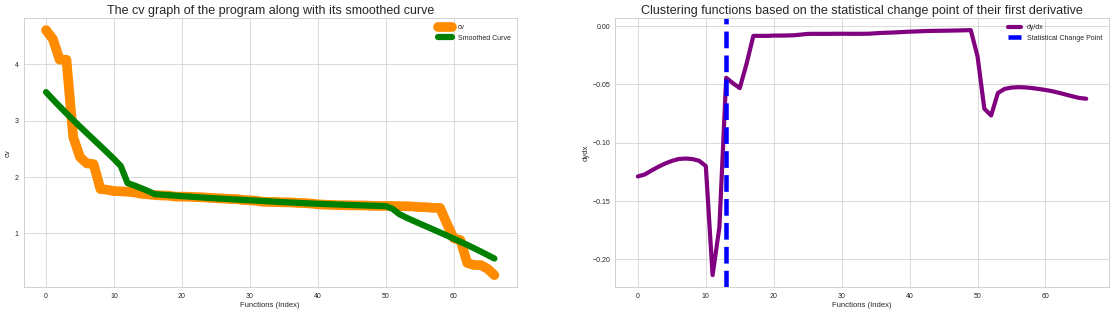

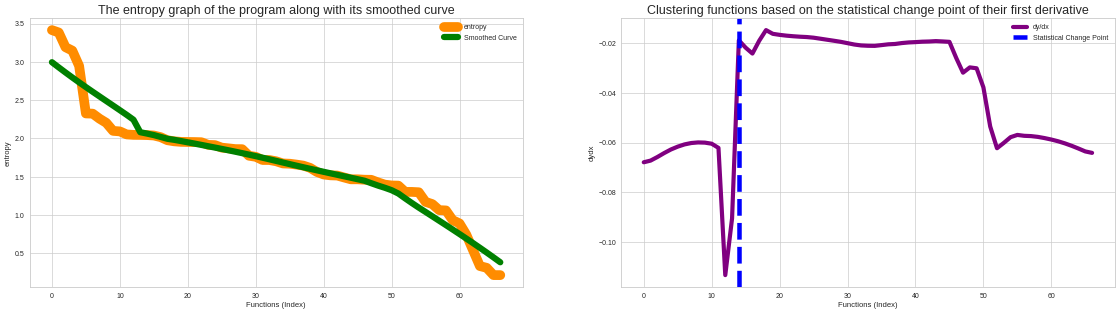

-----------------------------------------------------------------------------------------
638_imagick


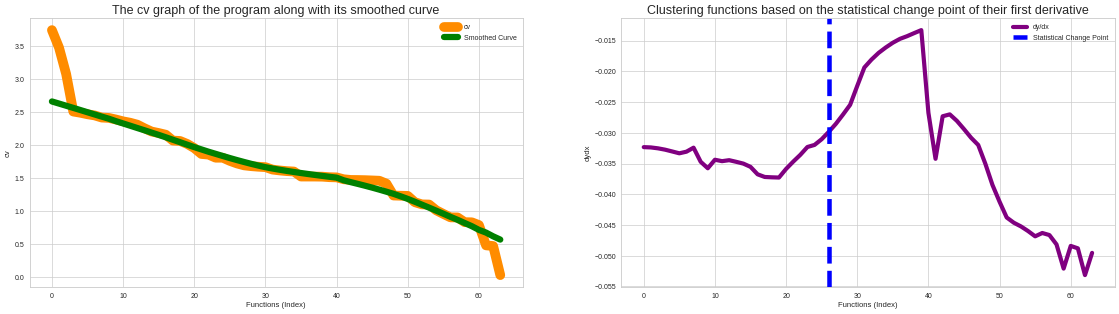

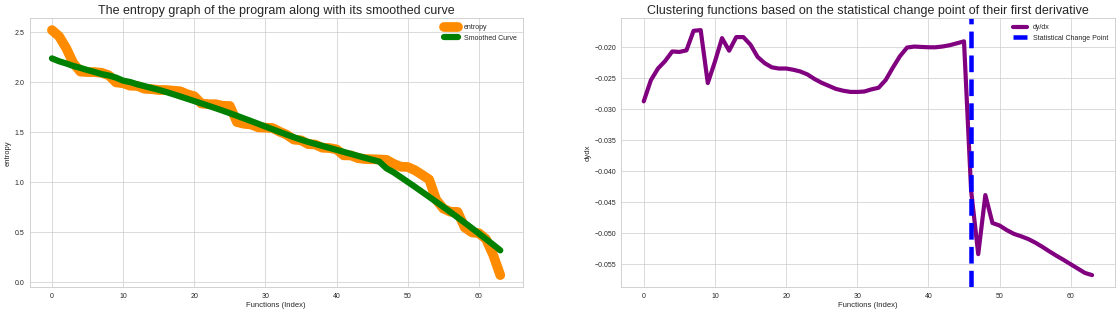

-----------------------------------------------------------------------------------------
su2_cfd


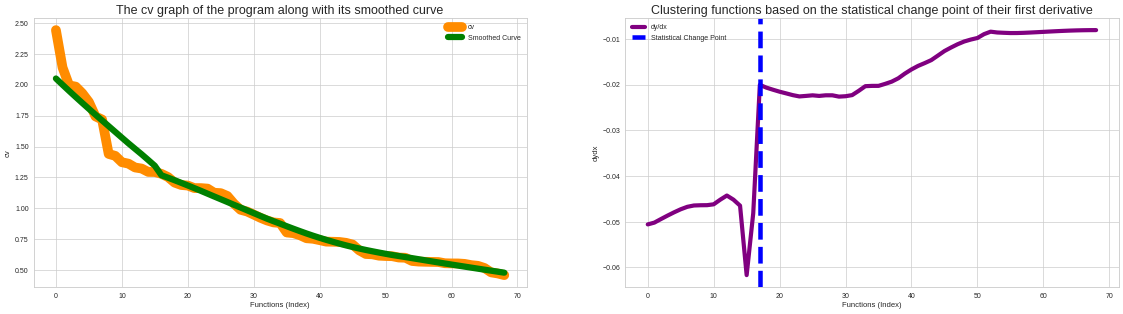

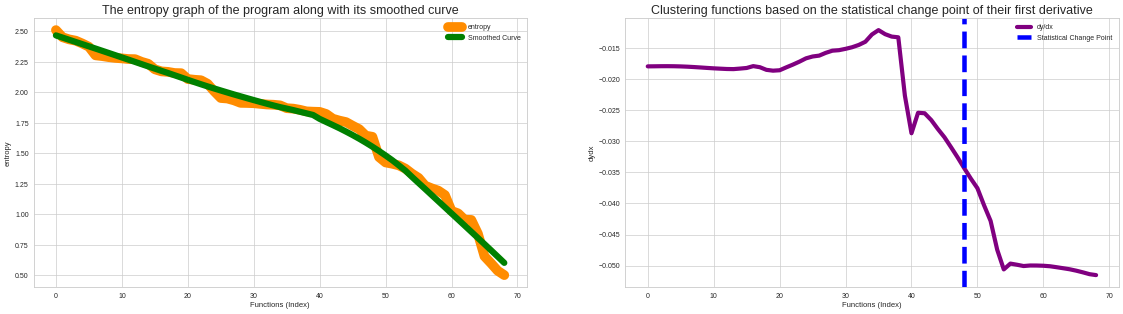

-----------------------------------------------------------------------------------------
parsec_freqmine


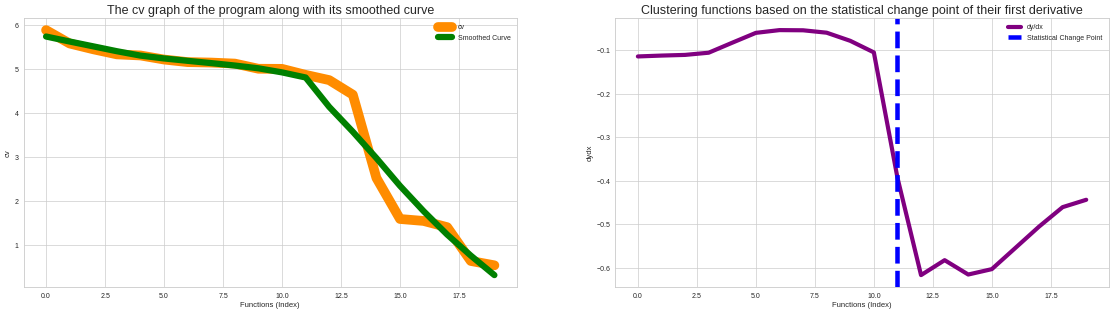

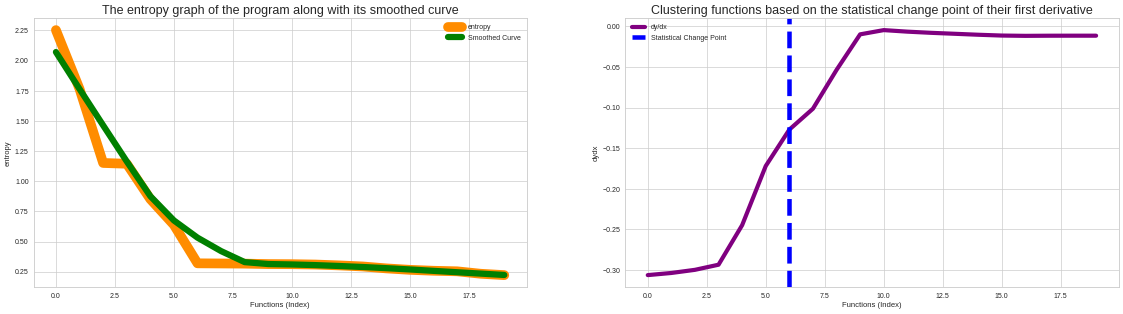

-----------------------------------------------------------------------------------------
657_xz


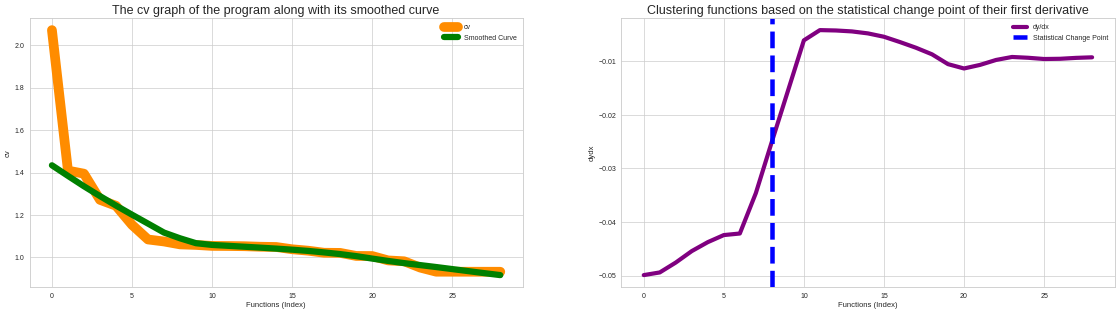

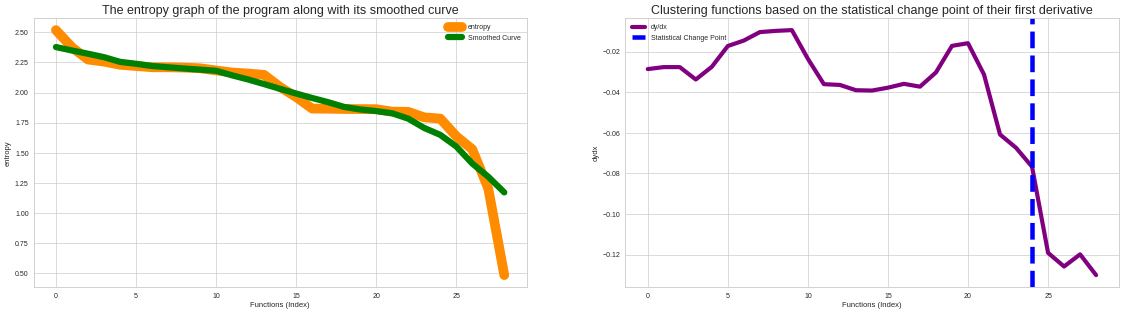

-----------------------------------------------------------------------------------------


In [58]:
plt.rcParams.update({'font.size': 20})

for program, modes in datasets.items():
    print(f"{bcolors.BOLD}{program}{bcolors.ENDC}")
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue

        for metric_name, metric in {'cv': cvs, 'entropy': entropies}.items():
            fig, axes = plt.subplots(1, 2, figsize=(28, 7), dpi=50)

            for i, ax in enumerate(axes):
                if i == 0:
                    ax.plot(list(metric[program][mode].values()), color='darkorange', label=metric_name, linewidth=14)
                    ax.plot(graphs[program][mode][metric_name]['smooth'], color='green', label='Smoothed Curve', linewidth=9)

                    ax.set_ylabel(metric_name)
                    ax.set_title(f"The {metric_name} graph of the program along with its smoothed curve", fontsize=18)
                elif i == 1:
                    ax.plot(list(graphs[program][mode][metric_name]['dydx']), color='purple', label='dy/dx', linewidth=6)
                    for l in graphs[program][mode][metric_name]['split']:
                        if l == 0:
                            continue
                        ax.axvline(x=l, color='blue', linestyle='--', label='Statistical Change Point', linewidth=6.5)

                    ax.set_ylabel("dydx")
                    ax.set_title("Clustering functions based on the statistical change point of their first derivative", fontsize=18)

                ax.set_xlabel("Functions (Index)")
                ax.legend()

            plt.show()
            # plt.savefig('graph.cv.pdf', pad_inches=0.05, bbox_inches='tight')
    print('-----------------------------------------------------------------------------------------')


In [59]:
# Again, fetch the trace datasets with the "functions' call frequencies" as the features
datasets = get_datasets(field='calls')

In [60]:
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue
        try:
            if program == '631_sjeng':
                datasets[program][mode] = datasets[program][mode].drop('int const& std::min<int>', axis=1)

            # Again, remove the functions with "unique call frequencies" less than 1% of the entire dataset (i.e., 25)
            uninformative_columns = [col for col in dataset[dataset.columns[dataset.columns != 'model_output']].columns if len(dataset[col].value_counts()) < 25]
            datasets[program][mode] = datasets[program][mode].drop(columns=uninformative_columns, axis = 1)
        except Exception as e:
            continue

In [61]:
# Test whether the data is distributed normal or non-normal. If nothig prints, so the data is distributed non-normal
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue

        for column in dataset.columns:
            if column == 'model_output':
                continue

            _, p_value_kstest = kstest(dataset[column], 'norm')
            _, p_value_shapiro = shapiro(dataset[column])

            if p_value_kstest > 0.05 or p_value_shapiro > 0.05:
                print(f'{column}: Data looks normally distributed (fail to reject H0)')


**Calculating the feature significance criterion.**
We build a simple linear regression model with the entire analysis dataset, and determine the features that have a significance impact on the model's performance. We use p-value < 0.05 as the threshold.

In [62]:
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue

        ndf = dataset.copy().sample(frac=1, ignore_index=True)
        X = ndf.iloc[:,1:]
        y = ndf.iloc[:,0]

        X_with_intercept = sm.add_constant(X)
        model = sm.OLS(y, X_with_intercept).fit()
        p_values = model.pvalues

        selected_features = []
        if p_values is not None:
            for i, p_value in enumerate(p_values[1:]):
                if p_value < 0.05:
                    selected_features.append(X.columns[i])

        significant_functions[program]['model_importance'] = selected_features

**Removing highly correlated functions.**
Using hierarchial correlation removal, we remove the highly correlate functions using the 0.7 threshold. We apply this removal to "entropy", "CV", and "correlation" sets.

In [63]:
# Removing highly correlated functions
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue
        for metric in ['entropy', 'cv', 'correlation']:
            ndf = dataset.copy()
            ndf = ndf[significant_functions[program][metric]]

            # We use spearman correlation since the data is distributed non-normal
            correlation_matrix = ndf.corr(method='spearman')
            linkage_matrix = hierarchy.linkage(correlation_matrix, method='average')

            threshold = 0.7

            clusters = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')

            feature_cluster_map = {}
            for feature, cluster in zip(correlation_matrix.columns, clusters):
                if cluster not in feature_cluster_map:
                    feature_cluster_map[cluster] = []
                feature_cluster_map[cluster].append(feature)

            selected_features = [cluster[0] for cluster in feature_cluster_map.values()]

            significant_functions[program][metric + '_correlation' if metric != 'correlation' else metric] = selected_features

**Finding the union of Entropy and CV sets.**
In order to comibe the characteristics of entropy and CV sets, we calculate their union, and make a new set of candidate functions from them. Accordingly, we will have two new sets:

1.   Entropy(w/o correlation removal) / CV(w/o correlation removal)
2.   Entropy(w/ correlation removal) / CV(w/ correlation removal)



In [64]:
# Calculate the union of the sets (e.g., etropy & CV)
for program in list(datasets.keys()):
    # These are the entropy and CV sets after applying the correlation removal (less number of functinos)
    entropy_corr_set = set(significant_functions[program]['entropy_correlation'])
    cv_corr_set = set(significant_functions[program]['cv_correlation'])

    # These are the original sets of entropy and CV (higher number of functions)
    entropy_set = set(significant_functions[program]['entropy'])
    cv_set = set(significant_functions[program]['cv'])

    # We also want to calculate the union of model significance functions with entropy, cv, and performance correlations
    model_importance_set = set(significant_functions[program]['model_importance'])
    correlation_set = set(significant_functions[program]['correlation'])

    sets = {'entropy': entropy_set, 'cv': cv_set, 'entropy_corr': entropy_corr_set, 'cv_corr': cv_corr_set, 'model_importance': model_importance_set, 'correlation': correlation_set}

    for set1, set2 in [('entropy', 'cv'), ('entropy_corr', 'cv_corr')]:
        union = list(sets[set1] | sets[set2])
        significant_functions[program][f'{set1}_and_{set2}'] = union

    for set1, set2, set3 in [('entropy_corr', 'cv_corr', 'model_importance')]:
        union = list(sets[set1] | sets[set2] | sets[set3])
        significant_functions[program][f'{set1}_and_{set2}_and_{set3}'] = union

**Full tracing.**
This set is just for tracing all of the functions in a program.

In [65]:
for program in list(datasets.keys()):
    significant_functions[program]['full'] = ['.']

In [66]:
print(json.dumps(significant_functions, indent=4))

{
    "631_sjeng": {
        "entropy": [
            "comp_to_san",
            "hash_extract_pv",
            "post_thinking",
            "myprintf",
            "rootmovesearch",
            "rtime",
            "rdifftime",
            "history_pre_cut",
            "history_bad",
            "interrupt",
            "add_capture",
            "static_pawn_eval",
            "drawn_endgames",
            "trapped_eval",
            "psq_eval"
        ],
        "cv": [
            "add_king_castle",
            "check_castle_blocker",
            "ProbeTT",
            "full_pawn_eval",
            "taxicab_dist",
            "taxicab_dist_bit",
            "gen_evasions",
            "passer_eval",
            "gen_check_blocks",
            "attacks_to",
            "file",
            "rank",
            "positional_eval",
            "search"
        ],
        "correlation": [
            "rootmovesearch",
            "search",
            "sum_dist",
            "taxicab_dis

## **Determining the regression injection spots**

In [67]:
datasets = get_datasets(field='calls')

In [68]:
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue
        try:
            """
            Some of the functions of this program has the same name, but different call type (e.g., function_name <type 1> and function_name <type 2>)
            Hence, we merge these functions into single ones (i.e., with respect to function's demangling, we only consider the function name).
            """
            if program == 'parsec_freqmine':
                repetitives = [col for col in datasets[program][mode].columns if ' ' in col or '<' in col]
                fixed = list(set([item.split(' ')[1].split('<')[0] for item in repetitives]))

                new_columns = {}
                for item in fixed:
                    for rep in repetitives:
                        if ' ' + item in rep:
                            if item not in new_columns:
                                new_columns[item] = datasets[program][mode][rep]
                            else:
                                new_columns[item] = new_columns[item] + datasets[program][mode][rep]

                    datasets[program][mode][item] = new_columns[item]

                # Remove this particular function since it was not in the program's source (i.e, it might be an external library call)
                repetitives.append('_GLOBAL__sub_I_ITlen')

                datasets[program][mode] = datasets[program][mode].drop(columns=repetitives)
            if program == '631_sjeng':
                # Remove this particular function since it was not in the program's source (i.e, it might be an external library call)
                datasets[program][mode] = datasets[program][mode].drop('int const& std::min<int>', axis=1)
        except Exception as e:
            print(e)
            continue

**Calculate the median number of calls for each function**

In [69]:
program_calls = {}
regression_targets = defaultdict(lambda: defaultdict(lambda: defaultdict(defaultdict)))
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode != 'analysis':
            continue

        calls = dict(sorted({column: int(np.percentile([c for c in dataset[column].to_list() if c > 0], 50)) for column in dataset.iloc[:,1:].columns}.items(), key=lambda item: item[1], reverse=False))

        for col in dataset.iloc[:,1:].columns:
            if np.min(datasets[program][mode][col].to_list()) < 1:
                if col in calls:
                    calls.pop(col)

        """
        We merge the functions that have the same median number of calls, and keep only one of them. This is because since we want to inject only one type of
        performance regression (i.e., constant delay), it doesn't matter if we insert this regression into a function with 8 median calls or to another function
        with the same median calls (The generated performance regression will be same since both of them execute the same number).
        """
        seen_values = set()
        non_repetitive = {}
        for key, value in calls.items():
            if value not in seen_values:
                non_repetitive[key] = value
                seen_values.add(value)

        analysis_list = non_repetitive

        program_calls[program] = non_repetitive

**Cluster the functions into three groups based on their median number of calls.**
Using the first and thirt quartiles, we cluster the functions into low-call, medium-call, and high-call.

In [70]:
def find_next_index(dictionary, target_value, checked_indices):
    for key, value in dictionary.items():
        if value == target_value and key not in checked_indices:
            checked_indices.add(key)
            return key

regression_targets = defaultdict(lambda: defaultdict(list))
for program, calls in program_calls.items():
    call_counts = list(calls.values())

    # Removing the outliers using z-score
    z_scores = np.abs(zscore(call_counts))
    z_score_threshold = 4
    call_counts = [call for i, call in enumerate(call_counts) if z_scores[i] <= z_score_threshold]

    q1 = np.percentile(call_counts, 25)
    q3 = np.percentile(call_counts, 75)

    call_data = {
        "low_calls": [],
        "med_calls": [],
        "high_calls": []
    }

    # Iterate through call_counts and categorize them
    for call_count in call_counts:
        if call_count <= q1:
            call_data["low_calls"].append(call_count)
        elif q1 < call_count <= q3:
            call_data["med_calls"].append(call_count)
        else:
            call_data["high_calls"].append(call_count)

    # Since the number of functions in parsec_freqmine program is so limited, we consider 4 functions in this case (instead of 5)
    if program != 'parsec_freqmine':
        number_of_functions = 5
    else:
        number_of_functions = 4

    if len(call_data["low_calls"]) < number_of_functions:
        num_to_fill = number_of_functions - len(call_data["low_calls"])
        call_data["low_calls"].extend(call_data["med_calls"][:num_to_fill])
        call_data["med_calls"] = call_data["med_calls"][num_to_fill:]

    if len(call_data["high_calls"]) < number_of_functions:
        num_to_fill = number_of_functions - len(call_data["high_calls"])
        call_data["high_calls"].extend(call_data["med_calls"][-num_to_fill:])
        call_data["med_calls"] = call_data["med_calls"][:-num_to_fill]

    random.seed(42)

    call_data = {
        category: random.sample(call_data[category], number_of_functions)
        for category in call_data
    }

    random.seed()

    for category, functions in call_data.items():
        checked_indices = set()
        for i in range(number_of_functions):
            func_name = find_next_index(calls, functions[i], checked_indices)
            func_calls = functions[i]
            regression_targets[program][category].append({'function': func_name, 'calls': func_calls})

print(json.dumps(regression_targets, indent=4))

{
    "631_sjeng": {
        "low_calls": [
            {
                "function": "main",
                "calls": 1
            },
            {
                "function": "myprintf",
                "calls": 146
            },
            {
                "function": "reset_piece_square",
                "calls": 3
            },
            {
                "function": "clear_tt",
                "calls": 2
            },
            {
                "function": "rtime",
                "calls": 41
            }
        ],
        "med_calls": [
            {
                "function": "in_check",
                "calls": 237278
            },
            {
                "function": "gen_captures",
                "calls": 85569
            },
            {
                "function": "gen_evasions",
                "calls": 15756
            },
            {
                "function": "check_legal",
                "calls": 338546
            },
            {
          

## **Performance Modeling**

In [71]:
datasets = get_datasets(field='calls', target='full')

In [72]:
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        if mode == 'analysis':
            continue

        if 'input_parameters' in dataset.columns:
            datasets[program][mode] = datasets[program][mode].drop('input_parameters', axis = 1)

        # Fix the naming of the feature
        regex = re.compile(r"\[|\]|<", re.IGNORECASE)
        datasets[program][mode].columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in datasets[program][mode].columns.values]

        datasets[program][mode] = datasets[program][mode].sample(frac=1, random_state=42)

**Train the performance models for each pruning method and evaluate their average perdiction error.**
For each pruning method (e.g., entropy or CV), we build different performance models (e.g., Linear Regression and Random Forest), and then, evaluate their prediction accuracy.

In [73]:
mode_list = ['full', 'entropy', 'entropy_correlation', 'cv', 'cv_correlation', 'entropy_and_cv', 'entropy_corr_and_cv_corr', 'correlation', 'model_importance', 'entropy_corr_and_cv_corr_and_model_importance', 'static_pure']

experiments = defaultdict(lambda: defaultdict((lambda: defaultdict(defaultdict))))
model_errors = defaultdict(lambda: defaultdict((lambda: defaultdict(defaultdict))))
models = defaultdict(lambda: defaultdict((lambda: defaultdict(defaultdict))))

def build_performance_models(program, mode, dataset):
    if len(dataset.columns) < 2:
        return

    input_dataset = dataset.copy()
    input_dataset = input_dataset.reindex(sorted(input_dataset.columns), axis=1)

    exp = RegressionExperiment()

    # We first check if the model has already saved in the storage as a pickle file
    check_directory = f'{MODELS_DIRECTORY_PATH}/{mode.split("_")[0]}'
    files = next(os.walk(check_directory), (None, None, []))[2]
    program_models_list = [file for file in files if re.match(program + '_' + mode + '_' + r'[A-Za-z]+\.pkl', file)]
    if len(program_models_list) > 0:
        for program_model in program_models_list:
            model_name = program_model.split('_')[-1].split('.')[0]
            with open(f'{check_directory}/{program_model}', 'rb') as f:
                model = pickle.load(f)
                models[program][mode][model_name] = model

            errors_file = f'{check_directory}/{program}_{mode}_{model_name}_errors.json'
            if os.path.exists(errors_file):
                with open(errors_file , 'r') as f:
                    errors = json.loads(f.read())
                    for e_name, e_value in errors.items():
                        model_errors[program][e_name][mode][model_name] = e_value

        experiment_file = f'{check_directory}/{program}_{mode}_experiment_data.pkl'
        if os.path.exists(experiment_file):
            experiments[program][mode] = exp.load_experiment(experiment_file, input_dataset)

        print(f'Loaded the performance model pickle file for {program} with mode {mode} of {mode.split("_")[0]}')
        return

    print(f'No saved performance model found for {program} with mode {mode}. Starting to train the models...')

    exp.setup(input_dataset, target = 'model_output', train_size=0.8, preprocess=False, verbose=False, session_id=42)

    # We exclude XGBoost and LightGBM since they take a very unreasonable training time on the datasets. Also, since the dummy regressor is not useful for our study, we ignore it during the model trainings.
    best_models = exp.compare_models(turbo=True, verbose=False, n_select=5, exclude=['xgboost', 'lightgbm', 'dummy'])

    for model in best_models:
        model_name = type(model).__name__
        tuned_model = exp.tune_model(model, n_iter=10, verbose=False)
        models[program][mode][model_name] = tuned_model

        predictions = exp.predict_model(tuned_model, verbose=False)
        errors = get_errors(predictions['model_output'], predictions['prediction_label'])

        for e_name, e_value in errors.items():
            model_errors[program][e_name][mode][model_name] = e_value

        with open(f'{check_directory}/{program}_{mode}_{model_name}.pkl', 'wb') as f:
            pickle.dump(tuned_model,f)

        with open(f'{check_directory}/{program}_{mode}_{model_name}_errors.json', 'w+') as f:
            json.dump(errors, f)

    experiments[program][mode] = exp
    exp.save_experiment(f'{check_directory}/{program}_{mode}_experiment_data.pkl')

    print(f'Finished building performance models for {program} with mode {mode}')

In [74]:
for program, modes in datasets.items():
    for mode, dataset in modes.items():
        # Only use the "optimized" datasets
        if not mode.startswith('optimized') or 'random' in mode:
            continue

        build_performance_models(program, mode, dataset)

Loaded the performance model pickle file for 631_sjeng with mode optimized_full_itself of optimized
Loaded the performance model pickle file for 631_sjeng with mode optimized_entropy_itself of optimized
Loaded the performance model pickle file for 631_sjeng with mode optimized_cv_itself of optimized
Loaded the performance model pickle file for 631_sjeng with mode optimized_correlation_itself of optimized
Loaded the performance model pickle file for 631_sjeng with mode optimized_model_importance_itself of optimized
Loaded the performance model pickle file for 631_sjeng with mode optimized_entropy_correlation_itself of optimized
Loaded the performance model pickle file for 631_sjeng with mode optimized_cv_correlation_itself of optimized
Loaded the performance model pickle file for 631_sjeng with mode optimized_entropy_and_cv_itself of optimized
Loaded the performance model pickle file for 631_sjeng with mode optimized_entropy_corr_and_cv_corr_itself of optimized
Loaded the performance mo

In [75]:
# Print the errors (R2 score)
for program, errors in model_errors.items():
    print(program)
    for error_type, model_err in errors.items():
        if error_type != 'R2':
            continue

        for program_type, errs in model_err.items():
            if program_type not in datasets[program] or not program_type.startswith("optimized"):
                continue

            print(bcolors.BOLD + '\t' + ' '.join(program_type.split('_')[1:-1]) + ' | ' + str(len(datasets[program][program_type].columns) - 1) + bcolors.ENDC)
            for model_name, error_val in errs.items():
                print('\t\tModel: '+ bcolors.BOLD + model_name + bcolors.ENDC, 'R2:', bcolors.BOLD + str(round(error_val, 3)) + bcolors.ENDC)

631_sjeng
	full | 98
		Model: HuberRegressor R2: 0.96
		Model: OrthogonalMatchingPursuit R2: 0.934
		Model: KNeighborsRegressor R2: 0.955
		Model: RandomForestRegressor R2: 0.951
		Model: ExtraTreesRegressor R2: 0.947
	entropy | 15
		Model: BayesianRidge R2: 0.997
		Model: LassoLars R2: 0.997
		Model: Lasso R2: 0.997
		Model: LinearRegression R2: 0.996
		Model: ElasticNet R2: 0.997
	cv | 14
		Model: LinearRegression R2: 0.974
		Model: Lasso R2: 0.975
		Model: BayesianRidge R2: 0.975
		Model: ElasticNet R2: 0.975
		Model: Ridge R2: 0.974
	correlation | 9
		Model: ElasticNet R2: 0.988
		Model: LassoLars R2: 0.988
		Model: Lasso R2: 0.988
		Model: Ridge R2: 0.988
		Model: Lars R2: 0.988
	model importance | 13
		Model: OrthogonalMatchingPursuit R2: 0.896
		Model: Lasso R2: 0.934
		Model: LassoLars R2: 0.935
		Model: BayesianRidge R2: 0.935
		Model: ElasticNet R2: 0.934
	entropy correlation | 2
		Model: ElasticNet R2: 0.23
		Model: LassoLars R2: 0.185
		Model: KNeighborsRegressor R2: 0.195


In [76]:
# Determining the best model and metric for each program (based on the models accuracy. It is not the cost-efficiency ratio!). We only consider R2 metric to compare the models.
best_criterion = defaultdict(lambda: defaultdict(lambda: defaultdict()))
for program, errors in model_errors.items():
    for error_type, model_err in errors.items():
        if error_type != 'R2':
            continue

        for program_type, errs in model_err.items():
            if program_type not in datasets[program]:
                continue

            if not program_type.startswith("optimized"):
                continue

            pt = ' '.join(program_type.split('_')[1:-1])

            # pt = pt + ' - ' + str(len(datasets[program][program_type].columns))

            for model_name, error_val in errs.items():
                if pt not in best_criterion[program]:
                    best_criterion[program][pt] = error_val

                if error_val > best_criterion[program][pt]:
                    best_criterion[program][pt] = error_val

                best_criterion[program] = dict(sorted(best_criterion[program].items(), key=lambda item: item[1], reverse=True))

In [77]:
best_criterion

defaultdict(<function __main__.<lambda>()>,
            {'631_sjeng': {'static pure': 0.9996659884667966,
              'entropy': 0.9970473806111948,
              'cv correlation': 0.989261866483342,
              'correlation': 0.9883813705110643,
              'entropy corr and cv corr': 0.9850707637682381,
              'cv': 0.975297480642524,
              'entropy and cv': 0.9706223946283553,
              'full': 0.9603735383568232,
              'model importance': 0.9351237832163928,
              'entropy corr and cv corr and model importance': 0.8791469400896259,
              'entropy correlation': 0.25803776249360455},
             '638_imagick': {'model importance': 0.9979694547319913,
              'entropy corr and cv corr and model importance': 0.9977533313816838,
              'correlation': 0.9975330663130387,
              'entropy correlation': 0.9968924865268411,
              'full': 0.9966981894930573,
              'entropy corr and cv corr': 0.99031509415589

In [78]:
for program in list(datasets.keys()):
    final_r2 = -math.inf
    final_mode_name = None
    final_mode = None
    for mode in mode_list:
        if (program == 'su2_cfd' and mode == 'static_pure') or (program == '657_xz' and mode == 'model_importance'):
            continue

        r2 = best_criterion[program][' '.join(mode.split('_'))]

        for m_name_, m_r2_ in model_errors[program]['R2'][f'optimized_{mode}_itself'].items():
            if m_r2_ == r2:
                m_name = m_name_

        if r2 > final_r2:
            final_mode_name = m_name
            final_r2 = r2
            final_mode = f'optimized_{mode}_itself'

    print(f"Program: {program}, Final Mode: {final_mode}, Final Mode Name: {final_mode_name}, Mean Absolute Error (MAE): {'{:.3f}'.format(model_errors[program]['MAE'][final_mode][final_mode_name])}, Root Mean Squared Error (RMSE): {'{:.3f}'.format(model_errors[program]['RMSE'][final_mode][final_mode_name])}, R-squared (R2): {'{:.3f}'.format(math.floor(final_r2 * 1000) / 1000.0)}")

Program: 631_sjeng, Final Mode: optimized_static_pure_itself, Final Mode Name: BayesianRidge, Mean Absolute Error (MAE): 0.031, Root Mean Squared Error (RMSE): 0.053, R-squared (R2): 0.999
Program: 638_imagick, Final Mode: optimized_model_importance_itself, Final Mode Name: CatBoostRegressor, Mean Absolute Error (MAE): 0.039, Root Mean Squared Error (RMSE): 0.065, R-squared (R2): 0.997
Program: su2_cfd, Final Mode: optimized_entropy_and_cv_itself, Final Mode Name: CatBoostRegressor, Mean Absolute Error (MAE): 0.145, Root Mean Squared Error (RMSE): 0.213, R-squared (R2): 0.998
Program: parsec_freqmine, Final Mode: optimized_correlation_itself, Final Mode Name: AdaBoostRegressor, Mean Absolute Error (MAE): 0.004, Root Mean Squared Error (RMSE): 0.005, R-squared (R2): 0.931
Program: 657_xz, Final Mode: optimized_static_pure_itself, Final Mode Name: BayesianRidge, Mean Absolute Error (MAE): 0.002, Root Mean Squared Error (RMSE): 0.003, R-squared (R2): 0.999


In [79]:
for program, modes in best_criterion.items():
    print(program)
    for mode, e_value in modes.items():
        if mode.replace(' ', '_') not in mode_list:
            continue

        print('\t' + mode + '  |  ' + str(e_value))

631_sjeng
	static pure  |  0.9996659884667966
	entropy  |  0.9970473806111948
	cv correlation  |  0.989261866483342
	correlation  |  0.9883813705110643
	entropy corr and cv corr  |  0.9850707637682381
	cv  |  0.975297480642524
	entropy and cv  |  0.9706223946283553
	full  |  0.9603735383568232
	model importance  |  0.9351237832163928
	entropy corr and cv corr and model importance  |  0.8791469400896259
	entropy correlation  |  0.25803776249360455
638_imagick
	model importance  |  0.9979694547319913
	entropy corr and cv corr and model importance  |  0.9977533313816838
	correlation  |  0.9975330663130387
	entropy correlation  |  0.9968924865268411
	full  |  0.9966981894930573
	entropy corr and cv corr  |  0.9903150941558946
	entropy and cv  |  0.9837046849574226
	static pure  |  0.9767313025554143
	entropy  |  0.9600604849648685
	cv  |  0.5065279366399147
	cv correlation  |  0.4279536021762167
su2_cfd
	entropy and cv  |  0.9981076603284322
	full  |  0.9980047014628277
	entropy  |  0.9974

In [80]:
new_error_list = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict())))
for program in list(datasets.keys()):
    for mode in mode_list:
        for error_type in ['MAE', 'RMSE', 'R2']:
            for model_name, model_error in model_errors[program][error_type]['optimized_' + mode + '_itself'].items():
                new_error_list[program][mode][model_name][error_type] = model_error

**Evaluating the overhead of different optimization criterion.**
We calculate the overheads of execution time and storage usage for each pruning method (e.g., Entropy or CV).

In [81]:
programs = ['su2_cfd', '638_imagick', '631_sjeng', 'parsec_freqmine', '657_xz']
overheads = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict())))

def get_full_stats(documents, parameters):
    for doc in documents:
        if doc['parameters'] == parameters:
            return doc
    return None

def convert_size(size_bytes):
    units = ['KB', 'MB', 'GB', 'TB']
    i = 0
    while size_bytes >= 1024 and i < len(units) - 1:
        size_bytes /= 1024.0
        i += 1
    return f"{size_bytes:.2f}{units[i]}"

for program in programs:
    print(f"{bcolors.BOLD}{program}{bcolors.ENDC}")

    # optimized_db = list(db[f'reports-{program}_optimized'].find())
    # vanilla_db = list(db[f'reports-{program}_vanilla'].find())

    with open(f'{TRACE_DATA_PATH}/{program}_optimized.json') as f:
        optimized_db = json.load(f)

    with open(f'{TRACE_DATA_PATH}/{program}_vanilla.json') as f:
        vanilla_db = json.load(f)

    for target in ['times', 'sizes']:
        print('Execution Time Overheads' if target == 'times' else 'Storage Usage Overheads', end=' => ')

        percents = {}
        for item in optimized_db:
            original_item = get_full_stats(vanilla_db, item['parameters'])
            if original_item is None:
                continue

            overhead_metrics = {
                'vanilla': 1 if target == 'sizes' else original_item[target]['vanilla'],
                'optimized': item[target]['full']
            }

            if target == 'times':
                val = ((overhead_metrics['optimized'] - overhead_metrics['vanilla']) / overhead_metrics['vanilla']) * 100
            else:
                val = overhead_metrics['optimized']

            if item['build']['type'] not in percents:
                percents[item['build']['type']] = []
            percents[item['build']['type']].append(val)
        for k,v in percents.items():
            if target == 'times':
                print(k + ' is:',str(round(np.mean(v),2)) + '%', end=', ')
                overheads[program][k]['time'] = np.mean(v)
            else:
                print(k + ' is:', convert_size(np.mean(v)), end=', ')
                overheads[program][k]['size'] = convert_size(np.mean(v))
        print()
    print('--------------------------')

su2_cfd
Execution Time Overheads => full is: 77.11%, entropy is: 34.68%, cv is: 4.59%, correlation is: 12.49%, model_importance is: 3.95%, entropy_correlation is: 12.52%, cv_correlation is: 2.23%, entropy_and_cv is: 35.39%, entropy_corr_and_cv_corr is: 14.28%, cv_correlation_random is: 1.62%, static_pure is: 1.66%, entropy_corr_and_cv_corr_and_model_importance is: 12.27%, 
Storage Usage Overheads => full is: 748.58MB, entropy is: 487.03MB, cv is: 23.29MB, correlation is: 140.88MB, model_importance is: 21.65MB, entropy_correlation is: 143.46MB, cv_correlation is: 7.45MB, entropy_and_cv is: 501.05MB, entropy_corr_and_cv_corr is: 147.29MB, cv_correlation_random is: 3.65MB, static_pure is: 3.64MB, entropy_corr_and_cv_corr_and_model_importance is: 158.77MB, 
--------------------------
638_imagick
Execution Time Overheads => full is: 168.37%, entropy is: 100.35%, cv is: 28.3%, correlation is: 28.29%, model_importance is: 23.08%, entropy_correlation is: 24.97%, cv_correlation is: 14.29%, entr

**Cost-Efficiency Ratio.**
In here, we calculate the cost-efficiency ratio. This metric indicates the ratio of accuracy change in the optimized performance model compared to the full tracing performance model agains the overhead reduction between the models. It can be described as follow:

$\textit{Cost-Efficiency Ratio} = \frac{\frac{\textit{Optimized Model's Accuracy ($R^2$)}}{\textit{Vanilla Model's Accuracy ($R^2$)}}}{\frac{\textit{Optimized Model's Overhead (Execution Time)}}{\textit{Vanilla Model's Overhead (Execution Time)}}}$

The higher ratio indicates less accuracy loss (or higher accuracy improvement) against higher overhead reduction. In contrast, a lower ratio shows less overhead reduction and higher accuracy loss (or less accuracy improvement).


In [82]:
from tabulate import tabulate

candidate_ratios = defaultdict(lambda: defaultdict(lambda: defaultdict()))

for program in list(datasets.keys()):
    print(f"{bcolors.BOLD}{program}{bcolors.ENDC}")
    for mode in mode_list:
        if mode == 'full':
            continue

        full_error_val = 0
        for _, full_model_error in new_error_list[program]['full'].items():
            if full_model_error['R2'] > full_error_val:
                full_error_val = full_model_error['R2']

        for model_name in new_error_list[program][mode].keys():
            if 'R2' not in new_error_list[program][mode][model_name] :
                continue

            optimized_error_val = new_error_list[program][mode][model_name]['R2']

            full_overhead = overheads[program]['full']['time']
            optimized_overhead = overheads[program][mode]['time']

            error_difference = optimized_error_val / full_error_val
            overhead_difference = optimized_overhead / full_overhead

            accuracy_overhead_metric = error_difference / overhead_difference

            # They are the same (same functions to be traced)
            if program == '657_xz' and mode == 'entropy_corr_and_cv_corr_and_model_importance':
                mode = 'entropy_corr_and_cv_corr'

            if candidate_ratios[program]['cost_ratio'].get('value', float('-inf')) < accuracy_overhead_metric:
                candidate_ratios[program]['cost_ratio']['value'] = accuracy_overhead_metric
                candidate_ratios[program]['cost_ratio']['mode'] = mode.replace('_', ' ')

            if candidate_ratios[program]['best_accuracy'].get('value', float('-inf')) < error_difference:
                candidate_ratios[program]['best_accuracy']['value'] = error_difference
                candidate_ratios[program]['best_accuracy']['mode'] = mode.replace('_', ' ')

            if candidate_ratios[program]['best_overhead'].get('value', float('inf')) > overhead_difference:
                candidate_ratios[program]['best_overhead']['value'] = overhead_difference
                candidate_ratios[program]['best_overhead']['mode'] = mode.replace('_', ' ')

    table = []
    headers = ["Best Cost-Ratio", "Least Accuracy Difference", "Most Overhead Reduction"]

    row = [
        f"{candidate_ratios[program]['cost_ratio']['mode']}\n{round(candidate_ratios[program]['cost_ratio']['value'], 3)}",
        f"{candidate_ratios[program]['best_accuracy']['mode']}\n{round((candidate_ratios[program]['best_accuracy']['value']-1) * 100, 2)}%",
        f"{candidate_ratios[program]['best_overhead']['mode']}\n{round((1 - candidate_ratios[program]['best_overhead']['value']) * 100, 2)}%"
    ]

    table.append(row)

    print(tabulate(table, headers, tablefmt="grid", numalign='center', stralign='center'))
    print()

631_sjeng
+---------------------+-----------------------------+---------------------------+
|   Best Cost-Ratio   |  Least Accuracy Difference  |  Most Overhead Reduction  |
+=====================+=============================+===========================+
| entropy correlation |         static pure         |    entropy correlation    |
|       281.606       |            4.09%            |           99.9%           |
+---------------------+-----------------------------+---------------------------+

638_imagick
+-------------------+-----------------------------+---------------------------+
|  Best Cost-Ratio  |  Least Accuracy Difference  |  Most Overhead Reduction  |
+===================+=============================+===========================+
| model importance  |      model importance       |      cv correlation       |
|       7.305       |            0.13%            |          91.51%           |
+-------------------+-----------------------------+---------------------------+

su2_

## **Regression Detection**

**Evaluate optimized performance models (with and without regression) on the new data (with and without regression).**
We test the difference of the predictions of two optimized performance models on the new data. We determine if the difference between the predictions is significant (i.e., using the p-value < 0.05 from Mann-Whitney U-test) and the effect size of this difference (i.e., small, medium, or large) using Cliff's Effect Delta Size.

Then, we determine the original optimized performance model (w/o regression) is capable to detect how many injected performance regression (i.e., out ot 15 injected regressions)

In [83]:
for program, modes in datasets.items():
    print(f"{bcolors.BOLD}{program}{bcolors.ENDC}")
    for mode, dataset in modes.items():
        if 'regression' not in mode or 'random' in mode:
            continue

        if len(dataset.columns) < 2:
            continue

        if 'baseline' in mode:
            n_mode = ('_'.join(mode.split('_')[1:-2]))
        else:
            n_mode = ('_'.join(mode.split('_')[1:-3]))

        # Train the performance models only with the pruning methodologies that are indicated from the cost-ratio criterion
        ratio_values = [r['mode'].replace(' ', '_') for r in candidate_ratios[program].values()]
        if n_mode not in ratio_values and n_mode != 'static_pure':
            continue

        build_performance_models(program, mode, dataset)

631_sjeng
Loaded the performance model pickle file for 631_sjeng with mode regression_entropy_correlation_const_delay_low-0 of regression
Loaded the performance model pickle file for 631_sjeng with mode regression_entropy_correlation_const_delay_low-1 of regression
Loaded the performance model pickle file for 631_sjeng with mode regression_entropy_correlation_const_delay_low-2 of regression
Loaded the performance model pickle file for 631_sjeng with mode regression_entropy_correlation_const_delay_low-3 of regression
Loaded the performance model pickle file for 631_sjeng with mode regression_entropy_correlation_const_delay_low-4 of regression
Loaded the performance model pickle file for 631_sjeng with mode regression_entropy_correlation_const_delay_medium-0 of regression
Loaded the performance model pickle file for 631_sjeng with mode regression_entropy_correlation_const_delay_medium-1 of regression
Loaded the performance model pickle file for 631_sjeng with mode regression_entropy_corr

**Evaluating the effectivess of optimized performance models in detecting performance regressions by comparing the performance models of different program versions (i.e., with and without regression)**

In [84]:
detections = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for program, modes in datasets.items():
    print(f"{bcolors.BOLD}{program}{bcolors.ENDC}")
    for mode, dataset in modes.items():
        if 'regression' not in mode or 'random' in mode:
            continue

        if 'baseline' in mode:
            n_mode = ('_'.join(mode.split('_')[1:-2]))
        else:
            n_mode = ('_'.join(mode.split('_')[1:-3]))

        ratio_values = [r['mode'].replace(' ', '_') for r in candidate_ratios[program].values()]
        if n_mode not in ratio_values:
            continue

        best_regression_detection = {'p-value': 0 if 'itself' in mode else 1, 'effect_size': 'N/A', 'effect_size_delta': 0, 'regression_model': None, 'original_model': None}
        exp = experiments[program][mode]

        for regression_model_name, regression_model in models[program][mode].items():
            regression_predictions = exp.predict_model(regression_model, verbose=False)
            for original_model_name, original_model in models[program][f'optimized_{n_mode}_itself'].items():
                original_predictions = exp.predict_model(original_model, verbose=False)

                y_true = original_predictions['model_output']
                original_pred = original_predictions['prediction_label']
                regression_pred = regression_predictions['prediction_label']

                original_ae = np.abs(y_true - original_pred)
                regression_ae = np.abs(y_true - regression_pred)

                _, p_value = mannwhitneyu(original_ae, regression_ae)
                delta, cliff = cliffs_delta(original_ae,regression_ae)

                if 'itself' in mode:
                    if p_value > best_regression_detection['p-value']:
                        best_regression_detection['p-value'] = p_value
                        best_regression_detection['effect_size'] = cliff
                        best_regression_detection['effect_size_delta'] = delta
                        best_regression_detection['regression_model'] = regression_model
                        best_regression_detection['original_model'] = original_model
                else:
                    if p_value < best_regression_detection['p-value'] or delta < best_regression_detection['effect_size_delta']:
                        best_regression_detection['p-value'] = p_value
                        best_regression_detection['effect_size'] = cliff
                        best_regression_detection['effect_size_delta'] = delta
                        best_regression_detection['regression_model'] = regression_model
                        best_regression_detection['original_model'] = original_model

        p_value = best_regression_detection['p-value']
        cliff = best_regression_detection['effect_size']
        delta = best_regression_detection['effect_size_delta']
        original_model_name = type(best_regression_detection['original_model']).__name__
        regression_model_name = type(best_regression_detection['regression_model']).__name__
        if 'itself' in mode:
            if p_value < 0.01:
                p_value_text = '<<0.01'
            elif p_value < 0.05:
                p_Value_text = '<<0.05'
            else:
                p_value_text = str(round(p_value, 3))

            print(f'Mode: {n_mode} | Original Model: {original_model_name} | Regression Model: {regression_model_name} | P-value: {p_value_text} | Effect Size [delta]: {cliff.upper()}.[{str(round(delta, 3))}]')
        else:
            if p_value > 0.05 or cliff == 'negligible':
                detections[program][n_mode]['negligible'] += 1
            else:
                detections[program][n_mode][cliff] += 1

631_sjeng
Mode: entropy_correlation | Original Model: ElasticNet | Regression Model: OrthogonalMatchingPursuit | P-value: 0.845 | Effect Size [delta]: NEGLIGIBLE.[-0.02]
Mode: static_pure | Original Model: Lasso | Regression Model: OrthogonalMatchingPursuit | P-value: 0.563 | Effect Size [delta]: NEGLIGIBLE.[0.058]
638_imagick
Mode: model_importance | Original Model: CatBoostRegressor | Regression Model: ExtraTreesRegressor | P-value: 0.077 | Effect Size [delta]: SMALL.[0.177]
Mode: cv_correlation | Original Model: LinearRegression | Regression Model: LassoLars | P-value: 0.575 | Effect Size [delta]: NEGLIGIBLE.[0.056]
su2_cfd
Mode: cv_correlation | Original Model: DecisionTreeRegressor | Regression Model: ExtraTreesRegressor | P-value: 0.772 | Effect Size [delta]: NEGLIGIBLE.[0.029]
Mode: entropy_and_cv | Original Model: CatBoostRegressor | Regression Model: CatBoostRegressor | P-value: <<0.01 | Effect Size [delta]: LARGE.[0.579]
parsec_freqmine
Mode: correlation | Original Model: Ela

**Static execution times comparison.** As a baseline, this performance evaluation method aims to determine the performance regressions in different program versions by just comparing their execution times (i.e., measuring the Mann-Whitney U-Test and Cliff's Delta Effect Size).

In [85]:
for program, modes in datasets.items():
    print(f"{bcolors.BOLD}{program}{bcolors.ENDC}")
    for mode, dataset in modes.items():
        if 'regression' not in mode or 'random' in mode:
            continue

        if 'baseline' in mode:
            n_mode = ('_'.join(mode.split('_')[1:-2]))
        else:
            n_mode = ('_'.join(mode.split('_')[1:-3]))

        ratio_values = [r['mode'].replace(' ', '_') for r in candidate_ratios[program].values()]
        if n_mode not in ratio_values:
            continue

        current_execution_times = dataset['model_output']
        original_execution_times = datasets[program][f'optimized_{n_mode}_itself']['model_output']

        _, p_value = mannwhitneyu(original_execution_times, current_execution_times)
        delta, cliff = cliffs_delta(original_execution_times, current_execution_times)

        if 'itself' in mode:
            if p_value < 0.01:
                p_value_text = '<<0.01'
            elif p_value < 0.05:
                p_Value_text = '<<0.05'
            else:
                p_value_text = str(round(p_value, 3))

            print(f'Mode: {n_mode}_direct | P-value: {p_value_text} | Effect Size [delta]: {cliff.upper()}.[{str(round(delta, 3))}]')
        else:
            if p_value > 0.05 or cliff == 'negligible':
                detections[program][f'{n_mode}_direct']['negligible'] += 1
            else:
                detections[program][f'{n_mode}_direct'][cliff] += 1

631_sjeng
Mode: entropy_correlation_direct | P-value: <<0.01 | Effect Size [delta]: MEDIUM.[0.406]
Mode: static_pure_direct | P-value: <<0.01 | Effect Size [delta]: LARGE.[0.494]
638_imagick
Mode: model_importance_direct | P-value: <<0.01 | Effect Size [delta]: SMALL.[-0.164]
Mode: cv_correlation_direct | P-value: <<0.01 | Effect Size [delta]: NEGLIGIBLE.[-0.103]
su2_cfd
Mode: cv_correlation_direct | P-value: 0.946 | Effect Size [delta]: NEGLIGIBLE.[-0.003]
Mode: entropy_and_cv_direct | P-value: 0.946 | Effect Size [delta]: NEGLIGIBLE.[-0.107]
parsec_freqmine
Mode: correlation_direct | P-value: <<0.01 | Effect Size [delta]: SMALL.[-0.177]
657_xz
Mode: static_pure_direct | P-value: 0.167 | Effect Size [delta]: NEGLIGIBLE.[0.062]


In [86]:
# The efficiency of the optimized performance models in detecting the performance regressions
print(json.dumps(detections, indent=4))

{
    "631_sjeng": {
        "entropy_correlation": {
            "large": 13,
            "medium": 2
        },
        "static_pure": {
            "large": 8,
            "medium": 4,
            "small": 1,
            "negligible": 2
        },
        "entropy_correlation_direct": {
            "medium": 4,
            "large": 1,
            "negligible": 6,
            "small": 4
        },
        "static_pure_direct": {
            "large": 3,
            "medium": 4,
            "small": 5,
            "negligible": 3
        }
    },
    "638_imagick": {
        "model_importance": {
            "medium": 6,
            "small": 4,
            "large": 5
        },
        "cv_correlation": {
            "negligible": 10,
            "small": 1,
            "large": 2,
            "medium": 2
        },
        "model_importance_direct": {
            "negligible": 7,
            "small": 3,
            "large": 4,
            "medium": 1
        },
        "cv_correlation